# AED - Questões de Negócio

O objetivo deste notebook é analisar e responder as questões de negócio proposta, utilizando técnicas de manipulação e visualização de dados, utilizando Python e SQL.

## Importação de Bibliotecas

In [3]:
import pandas as pd
import sqlite3

from utils import eda_visualization as eda

## Importação dos Dados

In [4]:
df = pd.read_csv('../data/clean_general_df.csv')

## Tratamento de Dados

### Transformação de Tipo de Variávies

In [5]:
# Transformando os tipos de variáveis de data para datetime.
date_vars = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp']

for col in date_vars:
    if col in list(df.columns):
        df[col] = pd.to_datetime(df[col], format="mixed", dayfirst= False, errors="coerce")
        df[col] = df[col].dt.floor('s')

# Transformando todos os tipos 'object' dos dataframes para 'category', com o objetivo de aumentar a eficiência nas manipulações.
for col in df.select_dtypes(include= 'object').columns:
    df[col] = df[col].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118763 entries, 0 to 118762
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118763 non-null  category      
 1   customer_id                    118763 non-null  category      
 2   order_status                   118763 non-null  category      
 3   order_purchase_timestamp       118763 non-null  datetime64[ns]
 4   order_approved_at              118602 non-null  datetime64[ns]
 5   order_delivered_carrier_date   116689 non-null  datetime64[ns]
 6   order_delivered_customer_date  115360 non-null  datetime64[ns]
 7   order_estimated_delivery_date  118763 non-null  datetime64[ns]
 8   order_item_id                  117933 non-null  float64       
 9   product_id                     117933 non-null  category      
 10  seller_id                      117933 non-null  category      
 11  

## Questões de Negócio

### Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

In [7]:
df1 = pd.DataFrame()

# meses do  período completo dos dados
df1["month"] = df["order_purchase_timestamp"].dt.to_period("M").copy()

# sazonalidade(empilha todos os anos por mês 1–12)
df1["month_of_year"] = df["order_purchase_timestamp"].dt.month.copy()

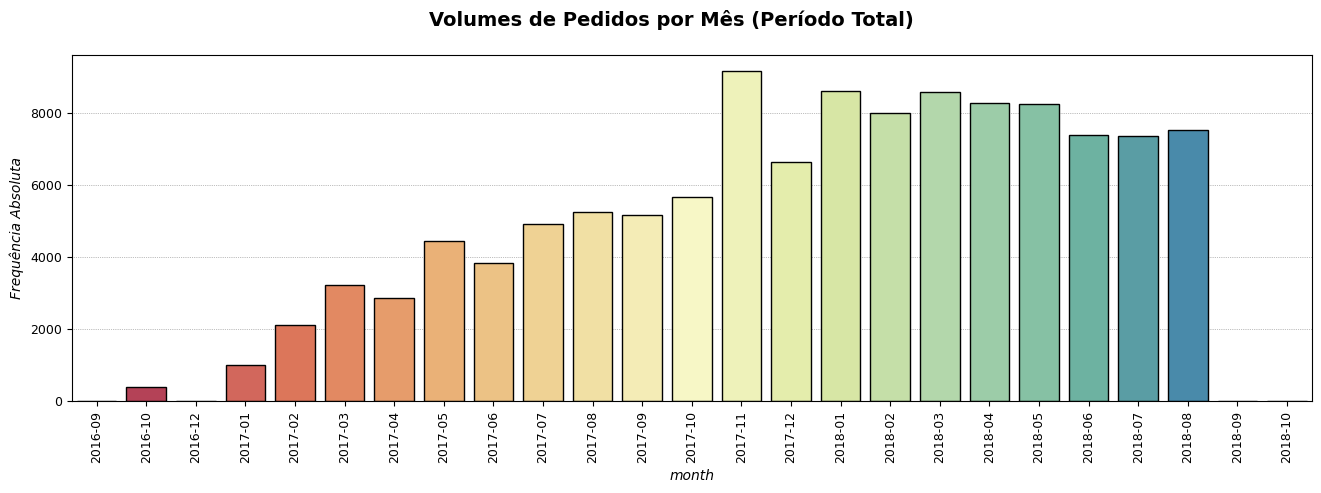

In [8]:
orders_per_month = df1['month'].sort_values(ascending= True).copy()
months = df1['month'].sort_values().unique().astype(str).tolist()
title = "Volumes de Pedidos por Mês (Período Total)"

eda.plot_ordinal_variable_distribution(orders_per_month, months, title)


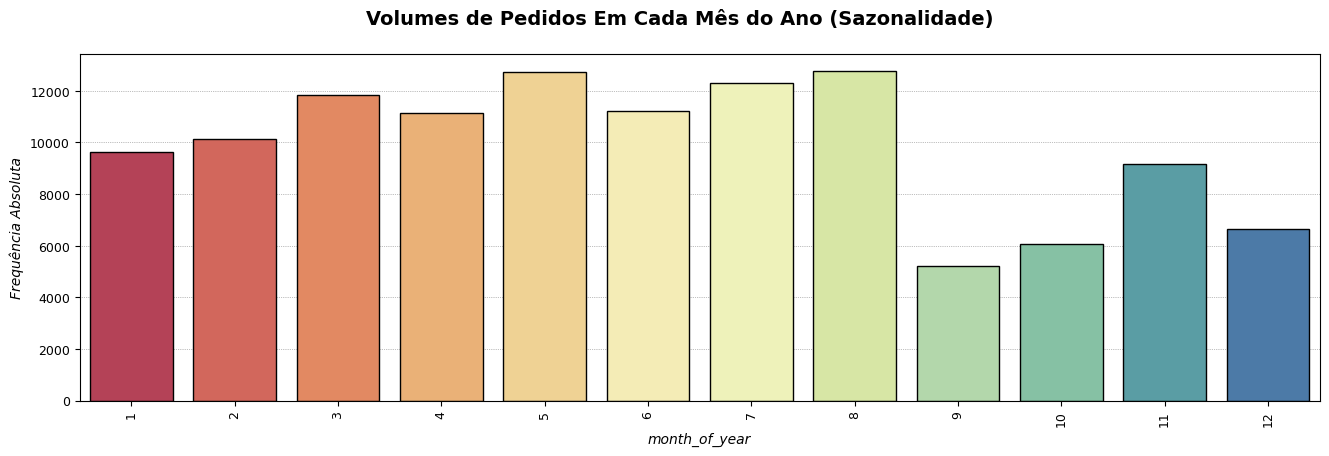

In [9]:
seasonality = df1['month_of_year'].sort_values(ascending= True).copy()
months = df1['month_of_year'].sort_values().unique().astype(str).tolist()
title = "Volumes de Pedidos Em Cada Mês do Ano (Sazonalidade)"

eda.plot_ordinal_variable_distribution(seasonality, months, title)

Com as visualizações plotadas para essa questão de negócio, é possível reconhecer que:
- O volume de pedidos cresce gradualmente no decorrer dos meses, desde o início do período da coleta de dados até o antepenultimo mês disponível. Porém, vale ressaltar que nos últimos meses do ano de 2016, o volume dos pedidos é extremamente pequeno e apresenta pouca constância, podendo evidenciar indisponibilidade de dados nesses períodos ou incapacidade de coleta dos dados. Os últimos meses do período (Agosto e Setembro de 2018) também apresentam pouquíssimo registros.
- Não se pode afirmar a existência de uma sazionalidade de pedidos, devido a ausência significativa de registros -em comparação aos outros meses- de pedidos nos últimos meses do ano.

## Qual a distribuição do tempo de entrega dos pedidos?

In [10]:
df2 = df[["order_delivered_customer_date", "order_purchase_timestamp"]].dropna(subset=["order_delivered_customer_date"]).copy()

df2["delivery_days"] = (
    df2["order_delivered_customer_date"] - df2["order_purchase_timestamp"]
).dt.days

df2["delivery_hours"] = round((
    df2["order_delivered_customer_date"] - df2["order_purchase_timestamp"]
) / pd.Timedelta(hours=1), 3)

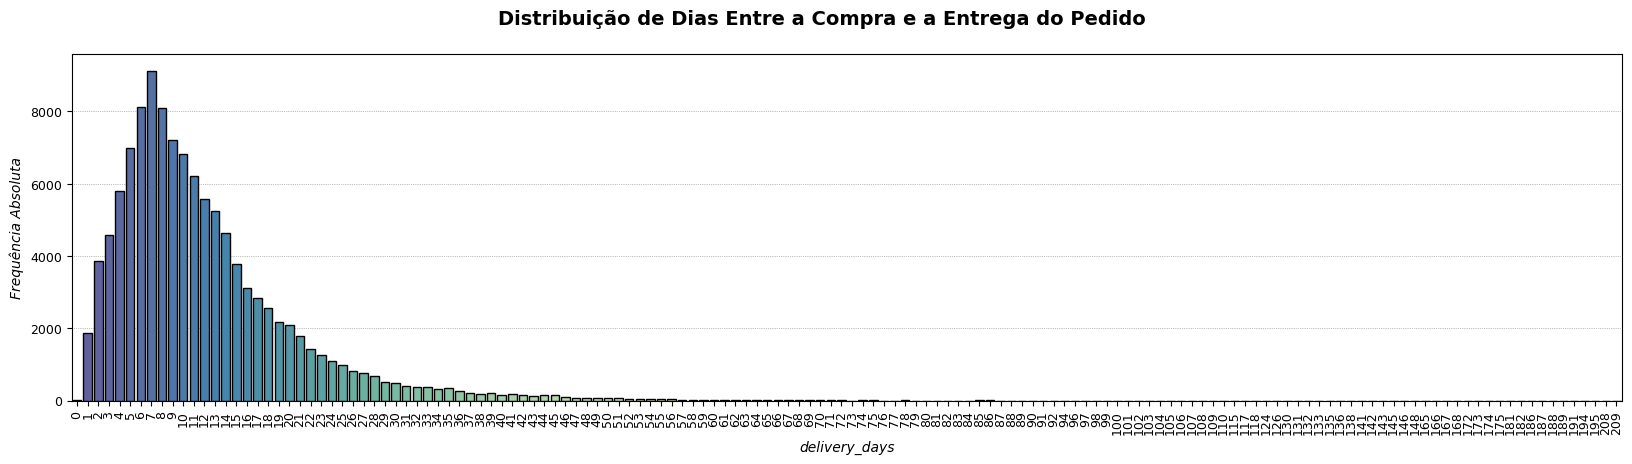

In [11]:
title = "Distribuição de Dias Entre a Compra e a Entrega do Pedido"
eda.plot_discrete_variable_distribution(df2['delivery_days'], title)

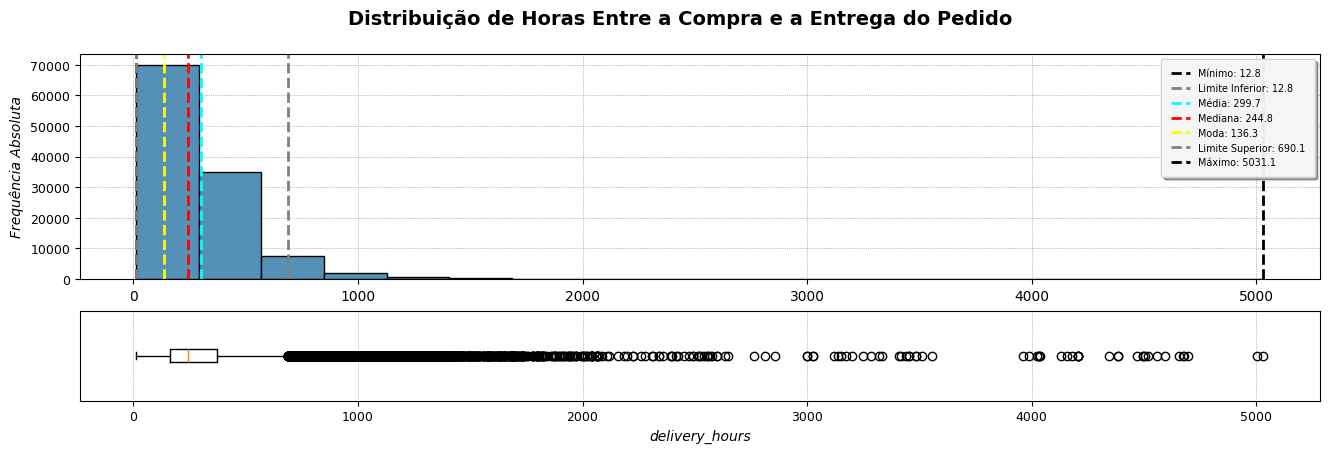

In [12]:
title = "Distribuição de Horas Entre a Compra e a Entrega do Pedido"
eda.plot_continuous_variable_distribution(df2["delivery_hours"], title)

Com a distribuição do tempo de entrega do pedido, conseguimos constatar que:
- A maior parte dos pedidos é entregue em até 10 dias. A distribuição apresenta picos entre os dias 5 e 7.
- A distribuição é assimétrica à direita, indicando que existem alguns pedidos que chegam bem após o valor médio esperado.

## Quais são as categorias de produtos mais vendidas em termos de faturamento?

In [16]:
db_path = '../data/olist.sqlite' 
conn = sqlite3.connect(db_path)

query = """
SELECT
    p.product_category_name,
    ROUND(SUM(pay.payment_value), 2) AS total_faturado
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
JOIN order_payments pay ON o.order_id = pay.order_id
WHERE o.order_status IN ('delivered', 'invoiced', 'shipped')
GROUP BY p.product_category_name
ORDER BY total_faturado DESC
LIMIT 10;
"""

df_result = pd.read_sql_query(query, conn)

print(">>> As Top 10 Categorias de Produtos Mais Vendidas (Faturamento):")
print(df_result)

>>> As Top 10 Categorias de Produtos Mais Vendidas (Faturamento):
    product_category_name  total_faturado
0         cama_mesa_banho      1959117.99
1            beleza_saude      1651556.57
2  informatica_acessorios      1567243.48
3      relogios_presentes      1415384.50
4        moveis_decoracao      1408566.91
5           esporte_lazer      1375838.55
6   utilidades_domesticas      1082688.79
7              automotivo       840964.31
8      ferramentas_jardim       820347.64
9              cool_stuff       755756.61


## Quais estados brasileiros possuem o maior valor médio de pedido?

In [17]:
query = """
WITH order_values AS (
    SELECT
        oi.order_id,
        SUM(oi.price) AS order_total
    FROM order_items oi
    GROUP BY oi.order_id
),
order_state AS (
    SELECT
        o.order_id,
        c.customer_state
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
),
order_totals_with_state AS (
    SELECT
        ov.order_id,
        ov.order_total,
        os.customer_state
    FROM order_values ov
    JOIN order_state os ON ov.order_id = os.order_id
)
SELECT
    customer_state,
    ROUND(AVG(order_total), 6) AS avg_order_value
FROM order_totals_with_state
GROUP BY customer_state
ORDER BY avg_order_value DESC;
"""

df_result = pd.read_sql_query(query, conn)

print('>>> Ordem de Estados Que Possuem O Maior Valor Médio de Pedido')
print(df_result)

conn.close()

>>> Ordem de Estados Que Possuem O Maior Valor Médio de Pedido
   customer_state  avg_order_value
0              PB       216.669323
1              AP       198.151471
2              AC       197.320370
3              AL       195.413163
4              RO       186.804211
5              PA       184.482278
6              TO       177.855699
7              PI       176.296308
8              MT       173.259723
9              RN       172.271743
10             CE       171.254491
11             SE       170.785072
12             RR       170.205000
13             MS       164.756897
14             MA       161.686784
15             PE       159.458756
16             BA       152.278139
17             AM       152.087347
18             GO       146.782237
19             SC       144.117757
20             RJ       142.931568
21             DF       142.401854
22             RS       138.126661
23             MG       137.327445
24             PR       136.671421
25             ES       135